## A. Kevin's NLTK NLP Text Analytics Pipeline V1

# NLP Pipeline for Interview Transcripts

## 1. Configuration

*Set up file paths and select the SpaCy model.*

## 2. Data Loading and Preprocessing

*Read CSV files and preprocess text data.*

## 3. Analysis

*Perform NLP analyses like tokenization, POS tagging, NER, etc.*

## 4. Visualization

*Visualize the results of the analyses.*

## 5. Results and Interpretation

*Interpret the findings and discuss insights.*


### 1.00 Installing Libraries and Dependencies

#needs 3.10 or 3.11 for spaCy 

1. conda update -n base -c conda-forge conda
2. conda create -n nltk-env python=3.11                 
3. conda activate nltk-env
4. conda install ipykernel jupyter nltk pandas numpy plotly matplotlib ipywidgets openpyxl seaborn -c conda-forge
5. pip install spacy
6. pip install sentence-transformers scikit-learn textblob nbformat ipython tqdm
6. python -m spacy download en_core_web_sm
7. python -m spacy download en_core_web_trf



### 1.01 NLTK Preprocessing and tokenization for Peeking under the Hood Text Analytics

Running the code cell below will result in us pulling the following token types for each of our seven corpora.
1. word tokens - formed from decomposing sentences into their constituent pieces.
2. NLTK text objects - The NLTK library has a unique tokenizer that adds additional metadata to the word token which allows for unique analysis as compared to normal word tokens.
3. original sentence tokens - based on numerous features, but normally bounded by punctuation marks. This is why we normally tokenize this first before other text processing.
4. normalized sentence tokens - original sentence tokens that have been lowercased, and had stop words, punctuations, and special chracters removed.

You can always figure out what type of data corpus you are dealing with by running these print checks. It is also extremely important to also note the importance of keeping your documents categorized, lest they get out of control. The more processing and feature extractions you do, the more you may end up with more different buckets of data to keep up with.
* We will look at the utility of each token type in these modules

CSV to corpus
folder_path = 'data/outputFiles/csvOutputs/diarizedTranscripts'

## New code

Note: you may need to restart the kernel to use updated packages.


## 1. Start pipeline

In [183]:
# Install ipywidgets if not already installed
# !pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

# Text input for the path to CSV files
path_input = widgets.Text(
    value='data/rawTranscriptFiles/interview_transcripts',
    placeholder='Enter the path to your CSV files',
    description='CSV Path:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

# Text input for the output path
output_path_input = widgets.Text(
    value='data/rawTranscriptFiles/interview_transcripts_output',
    placeholder='Enter the output path for processed files',
    description='Output Path:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

# Dropdown for selecting the SpaCy model
model_dropdown = widgets.Dropdown(
    options=['en_core_web_sm', 'en_core_web_md', 'en_core_web_lg'],
    value='en_core_web_sm',
    description='SpaCy Model:',
    disabled=False,
    layout=widgets.Layout(width='50%')
)

# Display the widgets
display(path_input, output_path_input, model_dropdown)


Text(value='data/rawTranscriptFiles/interview_transcripts', description='CSV Path:', layout=Layout(width='80%'…

Text(value='data/rawTranscriptFiles/interview_transcripts_output', description='Output Path:', layout=Layout(w…

Dropdown(description='SpaCy Model:', layout=Layout(width='50%'), options=('en_core_web_sm', 'en_core_web_md', …

In [58]:
#Define path to the folder containg csv files
# Use the widget values in your code
path_to_csv_files = path_input.value
path_to_csv_files_output = output_path_input.value
model = model_dropdown.value


In [186]:
import os
import glob
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import re
from textblob import TextBlob  # For sentiment analysis (optional)
from tqdm.notebook import tqdm

# Define the SpaCy model to use (ensure you have downloaded it, e.g., en_core_web_sm)
model = model  # Replace with your desired model if different
nlp = spacy.load(model)

# Download NLTK stopwords and tokenizers
nltk.download('stopwords')
nltk.download('punkt')  # For sentence and word tokenization
stop_words = set(stopwords.words('english'))

# 1. Function to read CSV files from a folder and its subfolders
def read_transcripts_from_folder(base_dir):
    csv_files = glob.glob(os.path.join(base_dir, '**/*.csv'), recursive=True)
    transcripts = []
    for file in csv_files:
        df = pd.read_csv(file)
        filename = os.path.splitext(os.path.basename(file))[0]  # Extract filename without extension
        transcripts.append((df, filename))
    return transcripts

# 2. Text preprocessing with SpaCy (no stopword removal yet)
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text using SpaCy
    doc = nlp(text)
    
    # Lemmatize and remove punctuation, no stopword removal yet
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    
    return ' '.join(tokens)

# 3. SpaCy POS, NER, and Dependency parsing analysis
def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]  # Part-of-speech tagging
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Named entity recognition
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]  # Dependency parsing
    return pos_tags, entities, dependencies

# 4. Sentiment analysis using TextBlob
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity  # Sentiment polarity and subjectivity

# 5. NLTK tokenization and text object creation
def nltk_tokenization_and_text_object(df):
    # Sentence tokens of unprocessed and processed text
    df['nltk_unprocessed_sentence_tokens'] = df['text'].apply(nltk.sent_tokenize)  # Unprocessed sentence tokens
    df['nltk_processed_sentence_tokens'] = df['cleaned_text'].apply(nltk.sent_tokenize)  # Processed sentence tokens
    
    # Word tokens of unprocessed and processed text
    df['nltk_unprocessed_word_tokens'] = df['text'].apply(nltk.word_tokenize)  # Unprocessed word tokens
    df['nltk_processed_word_tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)  # Processed word tokens
    
    # NLTK Text object for unprocessed text
    df['nltk_text_object'] = df['nltk_unprocessed_word_tokens'].apply(lambda tokens: nltk.Text(tokens))  # NLTK Text object for unprocessed text
    
    return df

# 6. Apply preprocessing and analysis to the 'text' column of each CSV
def preprocess_and_analyze_transcripts(transcripts):
    results = []
    
    for df, filename in tqdm(processed_transcripts, desc='Processing Transcripts'):
        df['cleaned_text'] = df['text'].apply(preprocess_text)  # Preprocess the text
        
        # Apply SpaCy analysis (POS tags, NER, Dependency parsing)
        df['pos_tags'], df['entities'], df['dependencies'] = zip(*df['text'].apply(spacy_analysis))
        
        # Word count and sentence length
        df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
        df['sentence_length'] = df['text'].apply(lambda x: len(x.split()))  # Original text sentence length
        
        # Sentiment analysis (polarity and subjectivity)
        df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['text'].apply(sentiment_analysis))
        
        # Apply NLTK tokenization and text object creation
        df = nltk_tokenization_and_text_object(df)
        
        results.append((df, filename))
        pass
    return results

# 7. Main pipeline function to process CSV files
def process_csv_files(base_dir):
    # Step 1: Read all transcripts from the CSV files
    transcripts = read_transcripts_from_folder(base_dir)
    
    # Step 2: Preprocess and analyze the transcripts
    processed_transcripts = preprocess_and_analyze_transcripts(transcripts)
    
    return processed_transcripts

# Example usage of the pipeline
if __name__ == "__main__":

    base_dir = path_to_csv_files  # Replace with your actual path containing CSV transcript files
    output_dir = path_to_csv_files_output  # Replace with your desired output directory for processed CSV files
    
    # Ensure the output directory exists (create it if it doesn't)
    os.makedirs(output_dir, exist_ok=True)
    
    # Process the CSV files
    processed_transcripts = process_csv_files(base_dir)
    
    # Save the processed CSV files with original filenames
    for df, filename in tqdm(processed_transcripts, desc='Saving as CSV Files'):
        # Define the desired column order
        column_order = [
            'sentence_number', 'speaker', 'cleaned_text', 'entities', 'word_count', 'sentence_length', 
            'sentiment_polarity', 'sentiment_subjectivity', 'nltk_unprocessed_sentence_tokens', 
            'nltk_processed_sentence_tokens', 'nltk_unprocessed_word_tokens', 'nltk_processed_word_tokens', 
            'nltk_text_object', 'pos_tags', 'dependencies'
        ]
        
        # Ensure all columns exist in the DataFrame to prevent KeyError
        existing_columns = [col for col in column_order if col in df.columns]
        
        # Save the DataFrame with reordered columns
        output_filename = f'processed_transcript_{filename}.csv'
        df[existing_columns].to_csv(os.path.join(output_dir, output_filename), index=False)
        pass
        print(f"Processed file saved as: {output_filename}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing Transcripts:   0%|          | 0/7 [00:00<?, ?it/s]

Processing Transcripts:   0%|          | 0/7 [00:00<?, ?it/s]

Processed file saved as: processed_transcript_20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240531_INT_MS_Vera_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240531_INT_MS_Xander_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240603_INT_MS_Uma_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240606_INT_MS_Gloria_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240612_INT_HS_Charles_2024-08-07_transcription.csv
Processed file saved as: processed_transcript_20240718_INT_HS_Neil_2024-08-07_transcription.csv


In [188]:
for df, filename in processed_transcripts:
    nltk_text_obj = df.attrs['nltk_text_object']
    # Now you can use nltk_text_obj for concordance

print(nltk_text_obj[0:10])  # Display the first 10 tokens
type(nltk_text_obj)

['Great', '.', 'Yeah', ',', 'so', 'to', 'get', 'off', ',', 'just']


nltk.text.Text

## 2. Checking the dataframes

In [189]:
# Print the first 10 rows of the first processed transcript
print(processed_transcripts[0][0].head(10))


     start      end                                               text  \
0   81.627   83.749                  OK, so I'll start recording then.   
1   84.229   84.650                                         All right.   
2   85.290   87.272                                  It's going great.   
3   87.492   87.872                                                OK.   
4   89.574   93.277  Yeah, so just a little bit first to kind of ge...   
5   93.957   95.118                          So what are you teaching?   
6   96.379   99.402  And are you involved in any roles outside of t...   
7   99.842  107.569  Yeah, so I currently teach biology, AP environ...   
8  108.390  110.852       It's like a 20-minute homeroom for freshmen.   
9  110.932  115.296  So they have a half lunch period and half this...   

                                               words     speaker  \
0  [{'word': 'OK,', 'start': 81.627, 'end': 81.98...  SPEAKER_02   
1  [{'word': 'All', 'start': 84.229, 'end': 84.36

# Filter stop words

In [115]:
# Combine all tokens from 'nltk_unprocessed_word_tokens' column
all_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()

# Filter out stopwords and non-alphabetic tokens
filtered_tokens = [word for word in all_tokens if word.lower() not in stop_words and word.isalpha()]

# Create NLTK Text object
nltk_text_obj_clean = nltk.Text(filtered_tokens)

## 2.00 Peeking Under The Hood Text Analytics 

### 2.01 Average Sentence Length
Average Sentence Length uses the total number of words and total number of sentences
in a corpus to calculate exactly what it says: the average sentence length.
While the equation is very basic and straightforward it provides information that can
be used to infer, for example, how complex sentences are on average throughout a
given text corpus.

In [203]:
from tqdm.notebook import tqdm  # For Jupyter notebooks; use 'tqdm' if running as a script
import pandas as pd

# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    metrics_list = []  # List to store all metrics

    # Initialize tqdm progress bar over the processed_transcripts
    for i, (df, filename) in enumerate(tqdm(processed_transcripts, desc='Calculating Metrics', unit='transcript')):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN

        # Ensure there are sentences to avoid division by zero
        if len(sentence_tokens) > 0:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Store metrics in a dictionary
        metrics = {
            'Transcript': filename,
            'Number of sentences': len(sentence_tokens),
            'Number of word tokens': len(word_tokens),
            'Average sentence length': average_sentence_length
        }
        metrics_list.append(metrics)

        # Prepare the result string
        result = f"\nTranscript {i + 1} ({filename}):\n" \
                 f"Number of sentences: {len(sentence_tokens)}\n" \
                 f"Number of word tokens: {len(word_tokens)}\n" \
                 f"Average sentence length: {average_sentence_length:.2f}"

        # Use tqdm.write() to print without disrupting the progress bar
        tqdm.write(result)

    # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df

# 2. Run the function and get the DataFrame
metrics_df = calculate_metrics(processed_transcripts)


Calculating Metrics:   0%|          | 0/7 [00:00<?, ?transcript/s]


Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of sentences: 1330
Number of word tokens: 20998
Average sentence length: 15.79

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of sentences: 663
Number of word tokens: 9991
Average sentence length: 15.07

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of sentences: 570
Number of word tokens: 8019
Average sentence length: 14.07

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of sentences: 860
Number of word tokens: 14700
Average sentence length: 17.09

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of sentences: 594
Number of word tokens: 10698
Average sentence length: 18.01

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of sentences: 545
Number of word tokens: 8650
Average sentence length: 15.87

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of sentences: 516
Number of word

In [202]:
from tqdm.notebook import tqdm  # For Jupyter notebooks; use 'tqdm' if running as a script

# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    # Initialize tqdm progress bar over the processed_transcripts
    for i, (df, filename) in enumerate(tqdm(processed_transcripts, desc='Calculating Metrics', unit='transcript', leave=True )):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN

        # Ensure there are sentences to avoid division by zero
        if sentence_tokens:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Prepare the result string
        result = f"\nTranscript {i + 1} ({filename}):\n" \
                 f"Number of sentences: {len(sentence_tokens)}\n" \
                 f"Number of word tokens: {len(word_tokens)}\n" \
                 f"Average sentence length: {average_sentence_length:.2f}"
        
        # Use tqdm.write() to print without disrupting the progress bar
        tqdm.write(result)
        # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df


# 2. Run the metric calculation on the processed transcripts
metrics_df = calculate_metrics(processed_transcripts)



Calculating Metrics:   0%|          | 0/7 [00:00<?, ?transcript/s]

NameError: name 'average_sentence_length' is not defined

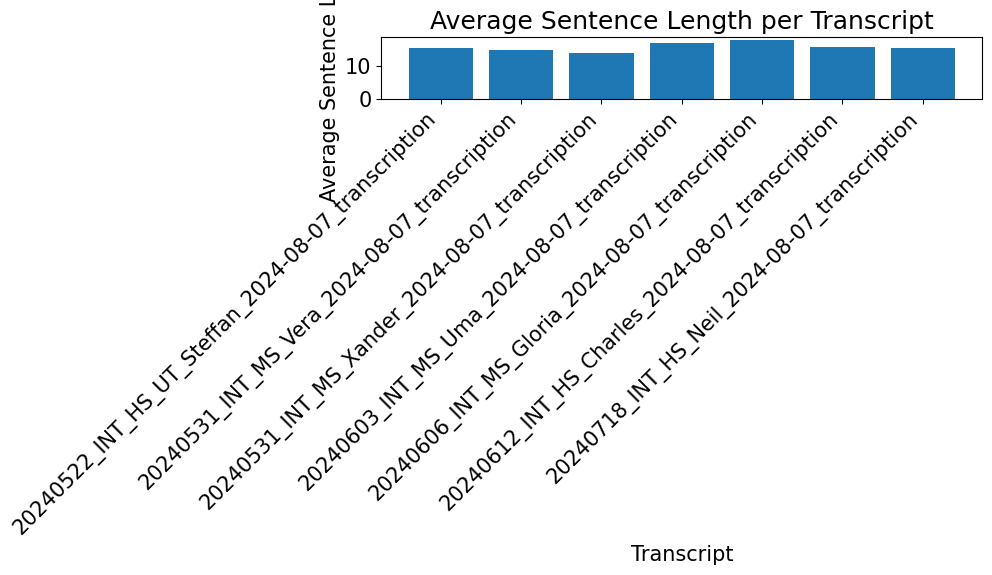

In [204]:
import matplotlib.pyplot as plt

# Plot average sentence length
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Transcript'], metrics_df['Average sentence length'])
plt.title('Average Sentence Length per Transcript')
plt.xlabel('Transcript')
plt.ylabel('Average Sentence Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [205]:
print(metrics_df)

                                          Transcript  Number of sentences  \
0  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...                 1330   
1      20240531_INT_MS_Vera_2024-08-07_transcription                  663   
2    20240531_INT_MS_Xander_2024-08-07_transcription                  570   
3       20240603_INT_MS_Uma_2024-08-07_transcription                  860   
4    20240606_INT_MS_Gloria_2024-08-07_transcription                  594   
5   20240612_INT_HS_Charles_2024-08-07_transcription                  545   
6      20240718_INT_HS_Neil_2024-08-07_transcription                  516   

   Number of word tokens  Average sentence length  
0                  20998                15.787970  
1                   9991                15.069382  
2                   8019                14.068421  
3                  14700                17.093023  
4                  10698                18.010101  
5                   8650                15.871560  
6                  

### 2.02 Average Word Length Distribution
Another fairly straightforward measure that can provide insight into how long, on average, words are in a given corpus.

In [210]:
from tqdm.notebook import tqdm  # For Jupyter notebooks; use 'tqdm' if running as a script

# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    # Initialize tqdm progress bar over the processed_transcripts
    for i, (df, filename) in enumerate(tqdm(processed_transcripts, desc='Calculating Metrics', unit='transcript')):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN

        # Ensure there are sentences to avoid division by zero
        if sentence_tokens:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Use tqdm.write() to print without disrupting the progress bar
        result = f"\nTranscript {i + 1} ({filename}):\n" \
                 f"Number of sentences: {len(sentence_tokens)}\n" \
                 f"Number of word tokens: {len(word_tokens)}\n" \
                 f"Average sentence length: {average_sentence_length:.2f}"
        tqdm.write(result)

# 2. Run the metric calculation on the processed transcripts
calculate_metrics(processed_transcripts)


Calculating Metrics:   0%|          | 0/7 [00:00<?, ?transcript/s]


Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of sentences: 1330
Number of word tokens: 20998
Average sentence length: 15.79

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of sentences: 663
Number of word tokens: 9991
Average sentence length: 15.07

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of sentences: 570
Number of word tokens: 8019
Average sentence length: 14.07

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of sentences: 860
Number of word tokens: 14700
Average sentence length: 17.09

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of sentences: 594
Number of word tokens: 10698
Average sentence length: 18.01

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of sentences: 545
Number of word tokens: 8650
Average sentence length: 15.87

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of sentences: 516
Number of word

### 2.03 Lexical Diversity
Lexical diversity quantifies the variety of unique words found in a document. It produces a numerical measure that indicates how diverse the vocabulary is that is used in a text. Broadly speaking, scores of (0.8 - 1) are considered extremely high and difficult to maintain in typical communicative texts. Scores of 0.4-0.79 are considered moderate to high; most high-quality texts fall in this range. Scores of (0 - 0.39) are considered low lexical diversity and tend to suggest highly specialized or technical language usage (e.g., instruction manuals) or language aimed at young readers. This measure is sensitive to corpus length (longer corpora have more opportunities to repeat words), but comparing lexical diversity scores can allow for quantitative comparison that might suggest potential changes in how the usage of language may differ between groups.

In [129]:
from nltk.corpus import stopwords
import string

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def calculate_lexical_diversity(processed_transcripts):
    for df, filename in processed_transcripts:
        nltk_text_obj = df.attrs.get('nltk_text_object', None)
        
        if nltk_text_obj is not None:
            # Filter tokens: remove stopwords and punctuation, and convert to lowercase
            filtered_tokens = [
                word.lower() for word in nltk_text_obj
                if word.lower() not in stop_words and word.isalpha()
            ]
            
            total_words = len(filtered_tokens)
            unique_words = len(set(filtered_tokens))
            lexical_diversity = unique_words / total_words if total_words > 0 else 0
            print(f"Lexical diversity for {filename}: {lexical_diversity:.3f}")
        else:
            print(f"No NLTK Text object available for {filename}")

calculate_lexical_diversity(processed_transcripts)

Lexical diversity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.198
Lexical diversity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.229
Lexical diversity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.248
Lexical diversity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.222
Lexical diversity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.204
Lexical diversity for 20240612_INT_HS_Charles_2024-08-07_transcription: 0.305
Lexical diversity for 20240718_INT_HS_Neil_2024-08-07_transcription: 0.293


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.04 Unique Words Over Time
Unique words can be used to identify the frequency of words that appear only once in a given corpus. We can also print a list of these word tokens. Looking at unique words between or across text corpora can allow us to look for the appearances and disappearances of specialized educational terminology over time. To find the frequency (number) of unique words, use the following code:

In [117]:
# 1. Function to calculate and print the number of unique words for each transcript
def calculate_unique_words(processed_transcripts):
    for i, (df, filename) in enumerate(processed_transcripts):
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Calculate the number of unique words
        unique_words = set(word_tokens)
        unique_word_count = len(unique_words)

        # Print results for each transcript
        print(f"\nTranscript {i + 1} ({filename}):")
        print("Number of unique words:", unique_word_count)

# 2. Run the unique word count calculation on the processed transcripts
calculate_unique_words(processed_transcripts)





Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
Number of unique words: 1806

Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
Number of unique words: 1000

Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
Number of unique words: 918

Transcript 4 (20240603_INT_MS_Uma_2024-08-07_transcription):
Number of unique words: 1333

Transcript 5 (20240606_INT_MS_Gloria_2024-08-07_transcription):
Number of unique words: 1030

Transcript 6 (20240612_INT_HS_Charles_2024-08-07_transcription):
Number of unique words: 1122

Transcript 7 (20240718_INT_HS_Neil_2024-08-07_transcription):
Number of unique words: 1021


# 2.05 Most common used words by corpus

In [132]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import nltk

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Calculate and print the top 10 most common words for each transcript
def calculate_most_common_words(processed_transcripts, top_n=10):
    for df, filename in processed_transcripts:
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)
        
        if nltk_text_obj is not None:
            # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
            filtered_tokens = [
                word.lower() for word in nltk_text_obj
                if word.lower() not in stop_words and word.isalpha()
            ]
            
            # Create a frequency distribution
            fdist = FreqDist(filtered_tokens)
            
            # Get the top N most common words
            most_common = fdist.most_common(top_n)
            
            print(f"Top {top_n} most common words in {filename}:")
            for word, frequency in most_common:
                print(f"{word}: {frequency}")
            print("\n")
        else:
            print(f"No NLTK Text object available for {filename}")

# 2. Run the frequency distribution calculation on the processed transcripts
calculate_most_common_words(processed_transcripts)


Top 10 most common words in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
like: 442
think: 240
know: 225
right: 173
yeah: 168
really: 139
students: 111
going: 100
things: 99
lot: 74


Top 10 most common words in 20240531_INT_MS_Vera_2024-08-07_transcription:
like: 357
yeah: 98
know: 85
okay: 72
um: 61
really: 46
oh: 41
going: 36
would: 31
get: 30


Top 10 most common words in 20240531_INT_MS_Xander_2024-08-07_transcription:
like: 170
kind: 116
yeah: 85
students: 49
really: 48
okay: 47
think: 35
get: 32
things: 31
would: 30


Top 10 most common words in 20240603_INT_MS_Uma_2024-08-07_transcription:
know: 260
like: 208
kind: 138
yeah: 80
science: 72
really: 71
things: 67
want: 62
going: 61
one: 59


Top 10 most common words in 20240606_INT_MS_Gloria_2024-08-07_transcription:
like: 527
think: 137
yeah: 105
um: 86
know: 75
things: 71
really: 52
okay: 46
kind: 44
feel: 44


Top 10 most common words in 20240612_INT_HS_Charles_2024-08-07_transcription:
like: 163
know: 87
think: 39
righ

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.05 Twenty-Five Most Frequent Words

In [116]:
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Function to calculate and print the top 25 most common words for each transcript
def calculate_most_common_words(processed_transcripts, top_n=25):
    for i, (df, filename) in enumerate(processed_transcripts):
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)
        
        # Check if nltk_text_obj exists
        if nltk_text_obj is not None:
            # Optionally filter out stopwords and non-alphabetic tokens
            filtered_words = [word for word in nltk_text_obj if word.lower() not in stop_words and word.isalpha()]
            
            # Generate a frequency distribution for the text object's words
            freq_dist = nltk.FreqDist(filtered_words)

            # Get the top N most common words
            most_common_words = freq_dist.most_common(top_n)

            # Print results for each transcript
            print(f"\nMost common words in Transcript {i + 1} ({filename}):")
            for word, count in most_common_words:
                print(f"{word}: {count}")
        else:
            print(f"No NLTK Text object available for Transcript {i + 1} ({filename})")

# 2. Run the frequency distribution calculation on the processed transcripts
calculate_most_common_words(processed_transcripts)





Most common words in Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
like: 393
think: 239
know: 225
right: 163
really: 139
Yeah: 111
students: 109
going: 100
things: 99
lot: 74
school: 62
get: 60
year: 60
mean: 60
yeah: 57
one: 51
also: 49
Like: 49
kind: 46
sort: 45
want: 45
classroom: 44
something: 43
say: 38
sometimes: 37

Most common words in Transcript 2 (20240531_INT_MS_Vera_2024-08-07_transcription):
like: 323
know: 85
yeah: 57
Okay: 54
really: 46
Yeah: 41
um: 38
going: 36
Like: 34
would: 31
get: 30
kind: 30
think: 29
science: 28
feel: 28
oh: 28
something: 24
got: 23
students: 23
Um: 23
right: 22
math: 22
use: 22
want: 22
one: 21

Most common words in Transcript 3 (20240531_INT_MS_Xander_2024-08-07_transcription):
like: 157
kind: 116
Yeah: 55
students: 49
really: 48
Okay: 39
think: 34
get: 32
things: 31
yeah: 30
kids: 29
would: 29
science: 27
go: 26
going: 26
unit: 25
trying: 23
year: 23
right: 22
talking: 21
use: 21
sure: 19
actually: 19
one: 19
thing: 18

M

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.06 Display all unique words found in a corpus

In [119]:
from nltk.corpus import stopwords
import string

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Create a dictionary where each key is the transcript filename and value is a set of word tokens
corpora_tokens = {}
for df, filename in processed_transcripts:
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Flatten the word tokens and filter out stopwords and non-alphabetic words
        tokens = set(
            word.lower() for word in df['nltk_unprocessed_word_tokens'].explode().tolist()
            if word.lower() not in stop_words and word.isalpha()
        )
        corpora_tokens[filename] = tokens
    else:
        print(f"'nltk_unprocessed_word_tokens' not found in {filename}")

# 2. Function to find words unique to each transcript compared to others
def find_unique_words(corpora_tokens):
    unique_words = {}
    for corpus_name, tokens in corpora_tokens.items():
        # Collect all tokens from other transcripts
        all_other_tokens = set()
        for other_corpus_name, other_tokens in corpora_tokens.items():
            if corpus_name != other_corpus_name:
                all_other_tokens.update(other_tokens)
        
        # Unique words are those not present in other transcripts
        unique_words[corpus_name] = tokens - all_other_tokens
    return unique_words

# 3. Find words unique to each transcript
unique_words_by_transcript = find_unique_words(corpora_tokens)

# 4. Print unique words for each transcript
for transcript_name, unique_words in unique_words_by_transcript.items():
    print(f"\nWords exclusive to {transcript_name}:")
    print(sorted(unique_words))



Words exclusive to 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
['abilities', 'absence', 'absenteeism', 'absolute', 'abysmally', 'academic', 'academically', 'accept', 'acknowledge', 'addendum', 'addiction', 'addictive', 'additionally', 'address', 'addresses', 'advisor', 'advocacy', 'advocating', 'air', 'albinism', 'allstate', 'alone', 'alternative', 'ama', 'american', 'amok', 'among', 'amorphous', 'amounts', 'amta', 'andrew', 'anecdotes', 'animals', 'antibiotic', 'app', 'arctic', 'association', 'assumptions', 'attempts', 'attitude', 'august', 'auto', 'backgrounds', 'badass', 'balanced', 'bar', 'battle', 'bearing', 'beautiful', 'bed', 'beef', 'beforehand', 'behaviorally', 'benefits', 'biochem', 'blah', 'blast', 'blue', 'brave', 'breakdown', 'brother', 'brush', 'buckle', 'bump', 'buzzing', 'cafe', 'campus', 'canada', 'canceled', 'candy', 'card', 'carrot', 'cases', 'caveats', 'celebrate', 'central', 'challenged', 'champagne', 'charm', 'checked', 'chemphys', 'chicken', 'chill', 'c

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.07 Most frequently used words across all corpora:

In [120]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Aggregate all word tokens from all transcripts into a single list
all_tokens = []
for df, filename in processed_transcripts:  # Unpack the tuple (DataFrame, filename)
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Flatten the word tokens
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()
        
        # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
        filtered_tokens = [
            word.lower() for word in word_tokens
            if word.lower() not in stop_words and word.isalpha()
        ]
        
        all_tokens.extend(filtered_tokens)
    else:
        print(f"'nltk_unprocessed_word_tokens' not found in {filename}")

# 2. Calculate the frequency distribution of all tokens
token_freq_dist = Counter(all_tokens)

# 3. Find the most common words across all transcripts (adjust the number as needed)
most_common_words = token_freq_dist.most_common(100)

# 4. Function to print data in columns
def print_in_columns(data, columns=3):
    # Split the data into chunks of size 'columns'
    for i in range(0, len(data), columns):
        chunk = data[i:i + columns]
        # Format and print each chunk
        print("  ".join(f"{word}: {freq}" for word, freq in chunk))

# 5. Print the most common words in columns
print("Most frequently used words across all transcripts:")
print_in_columns(most_common_words, columns=1)


Most frequently used words across all transcripts:
like: 1987
know: 785
yeah: 606
think: 557
kind: 426
really: 393
things: 338
students: 302
right: 294
okay: 293
going: 284
um: 271
get: 232
year: 217
science: 214
one: 213
would: 200
lot: 199
want: 183
school: 176
something: 175
well: 151
go: 140
unit: 140
little: 132
also: 131
time: 125
feel: 124
see: 122
kids: 121
curriculum: 120
mean: 118
work: 117
got: 117
make: 114
oh: 113
way: 113
different: 113
thing: 112
trying: 112
classroom: 109
teaching: 107
use: 104
last: 102
grade: 101
could: 96
sometimes: 93
maybe: 93
class: 92
say: 91
teacher: 90
much: 90
working: 87
student: 86
bit: 84
try: 84
need: 81
sort: 80
development: 80
years: 80
day: 78
back: 78
great: 77
talking: 77
actually: 77
professional: 76
good: 76
probably: 75
might: 73
questions: 73
even: 73
talk: 72
still: 72
done: 70
two: 68
said: 67
always: 67
ownership: 67
people: 66
part: 66
thinking: 65
look: 64
first: 63
teach: 62
next: 62
come: 62
every: 61
summer: 60
cool: 60
ge

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.08 N-grams and collocations
N-grams point out recurring word combinations found throughout the text corpus. For example, "spring break" is an example of a bigrams while "New York City" is a trigrams. Bigrams and repeated collocations of words convey a lot of information about the contents of the text corpus.
To generate an ordered list of the most common bigrams, use the following code:

In [122]:
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Loop through each transcript to find and display top bigrams and trigrams
for i, (df, filename) in enumerate(processed_transcripts):  # Unpack the tuple (DataFrame, filename)
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Filter out stopwords and non-alphabetic tokens, and convert to lowercase
        filtered_tokens = [
            word.lower() for word in word_tokens
            if word.lower() not in stop_words and word.isalpha()
        ]

        # Display frequency of highest 50 bigrams
        print(f"\nTop 50 bigrams for Transcript {i + 1} ({filename}):")
        bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)

        # Apply frequency filter to remove less frequent bigrams (optional)
        bigram_finder.apply_freq_filter(2)  # Adjust the minimum frequency as needed

        # Get the top 50 bigrams using raw frequency
        bigrams = bigram_finder.ngram_fd.most_common(50)
        for bigram, freq in bigrams:
            print(f"{bigram}: {freq}")

        # Display frequency of highest 50 trigrams
        print(f"\nTop 50 trigrams for Transcript {i + 1} ({filename}):")
        trigram_finder = TrigramCollocationFinder.from_words(filtered_tokens)

        # Apply frequency filter to remove less frequent trigrams (optional)
        trigram_finder.apply_freq_filter(2)  # Adjust the minimum frequency as needed

        # Get the top 50 trigrams using raw frequency
        trigrams = trigram_finder.ngram_fd.most_common(50)
        for trigram, freq in trigrams:
            print(f"{trigram}: {freq}")

    else:
        print(f"'nltk_unprocessed_word_tokens' column not found in {filename}")

    print("\n")



Top 50 bigrams for Transcript 1 (20240522_INT_HS_UT_Steffan_2024-08-07_transcription):
('know', 'mean'): 36
('know', 'like'): 36
('things', 'like'): 31
('yeah', 'yeah'): 24
('like', 'know'): 24
('right', 'like'): 22
('mean', 'like'): 21
('gon', 'na'): 18
('like', 'oh'): 14
('think', 'sometimes'): 14
('like', 'yeah'): 13
('little', 'bit'): 12
('like', 'really'): 12
('like', 'think'): 12
('yeah', 'like'): 11
('also', 'think'): 11
('last', 'year'): 11
('professional', 'development'): 10
('think', 'lot'): 10
('right', 'think'): 10
('next', 'year'): 9
('students', 'like'): 9
('okay', 'yeah'): 8
('really', 'hard'): 8
('think', 'students'): 8
('like', 'right'): 8
('yeah', 'know'): 8
('school', 'know'): 7
('really', 'good'): 7
('like', 'going'): 7
('yeah', 'okay'): 7
('think', 'really'): 7
('sounds', 'like'): 7
('know', 'know'): 7
('cool', 'cool'): 7
('right', 'yeah'): 6
('right', 'want'): 6
('day', 'day'): 6
('like', 'okay'): 6
('know', 'yeah'): 6
('talk', 'like'): 6
('lot', 'students'): 6
(

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.09 Concordance
Concordance is an NLTK Text object method that also looks for word distribution, but specifically searches for words found before and after a specific word of choice. Concordance allows us to find out how words are used contextually throughout a corpus. This can be particularly powerful when looking at trends over time or between groups. For example, in the sample below we search for the all the contextual occurrences of the word “pi” in our seven separate corpora.

In [123]:
# Example: Use concordance method to find occurrences of a word across all texts
word_to_search = 'equity'  # Replace with the word you want to search

for df, filename in processed_transcripts:
    nltk_text_obj = df.attrs['nltk_text_object']
    print(f"Concordance for '{word_to_search}' in {filename}:")
    try:
        nltk_text_obj.concordance(word_to_search, width=150)
    except Exception as e:
        print(f"Error in {filename}: {e}")
    print("\n")


Concordance for 'equity' in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
Displaying 4 of 4 matches:
 I 'm going to say equitable , because I also think that we have a huge equity issue right now in education , in that I do n't think that we are expec
ut of them and not teaching them as in-depth a content amount is a huge equity issue . You know what I mean ? Like if we 're not , if we 're teaching 
ink it 's often done in the name of , in sort of falsely in the name of equity , you know what I mean ? Like , I think that there 's a lot of linguist
ot by saying we 're not going to read because I think that gets to that equity issue and exacerbates our problem , right ? Like we need our students t


Concordance for 'equity' in 20240531_INT_MS_Vera_2024-08-07_transcription:
no matches


Concordance for 'equity' in 20240531_INT_MS_Xander_2024-08-07_transcription:
Displaying 1 of 1 matches:
hing . But most of our PDs is kind of surrounded by engaging students , equity for students , 

# Concordance with Multiple Words:

In [124]:
# Define the words to search for
words_to_search = ['equity', 'students', 'teachers']  # Add more words as needed

# Loop through each word
for word in words_to_search:
    print(f"\nConcordance for '{word}':")
    # Loop through each transcript
    for df, filename in processed_transcripts:
        # Access the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs['nltk_text_object']
        print(f"File: {filename}")
        try:
            nltk_text_obj.concordance(word, width=125)
        except Exception as e:
            print(f"Error in {filename}: {e}")
        print("\n")



Concordance for 'equity':
File: 20240522_INT_HS_UT_Steffan_2024-08-07_transcription
Displaying 4 of 4 matches:
o say equitable , because I also think that we have a huge equity issue right now in education , in that I do n't think that
d not teaching them as in-depth a content amount is a huge equity issue . You know what I mean ? Like if we 're not , if we 
en done in the name of , in sort of falsely in the name of equity , you know what I mean ? Like , I think that there 's a lo
we 're not going to read because I think that gets to that equity issue and exacerbates our problem , right ? Like we need o


File: 20240531_INT_MS_Vera_2024-08-07_transcription
no matches


File: 20240531_INT_MS_Xander_2024-08-07_transcription
Displaying 1 of 1 matches:
st of our PDs is kind of surrounded by engaging students , equity for students , just not so much in curriculum based things


File: 20240603_INT_MS_Uma_2024-08-07_transcription
no matches


File: 20240606_INT_MS_Gloria_2024-08-07_transcrip

# Generating Concordance-like Contexts (Looking for Similar Words):

In [138]:
import nltk

# 1. Function to find and print words similar to 'equity' in each transcript
def find_similar_words(processed_transcripts, target_word):
    # Convert the target word to the appropriate case, depending on your preprocessing
    target_word = target_word.lower()  # Adjust based on your preprocessing

    for df, filename in processed_transcripts:
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)

        if nltk_text_obj is not None:
            print(f"Words similar to '{target_word}' in {filename}:")
            try:
                # Ensure that the context index is built
                nltk_text_obj.similar(target_word)
            except Exception as e:
                print(f"Error in {filename}: {e}")
            print("\n")
        else:
            print(f"No NLTK Text object available for {filename}")

# 2. Run the similar words function on the processed transcripts
find_similar_words(processed_transcripts, target_word='school')


Words similar to 'school' in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
that it them year time what teaching and like this other empower lot
building semester support subject unit phone right


Words similar to 'school' in 20240531_INT_MS_Vera_2024-08-07_transcription:
like it them you what and teach the this say last curiosity person
problem times elements draw convincing changes


Words similar to 'school' in 20240531_INT_MS_Xander_2024-08-07_transcription:
whole last pd next cause cup changes


Words similar to 'school' in 20240603_INT_MS_Uma_2024-08-07_transcription:
science whole classroom them beginning last next majority time
university end empower parts culture nature challenges concept
schoolers rest mundane


Words similar to 'school' in 20240606_INT_MS_Gloria_2024-08-07_transcription:
time last unit first the it way that this what college science circus
classes kids things or spark one help


Words similar to 'school' in 20240612_INT_HS_Charles_2024-08-07_transcrip

# 6. Context Dispersion Plot:

Dispersion plot for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:


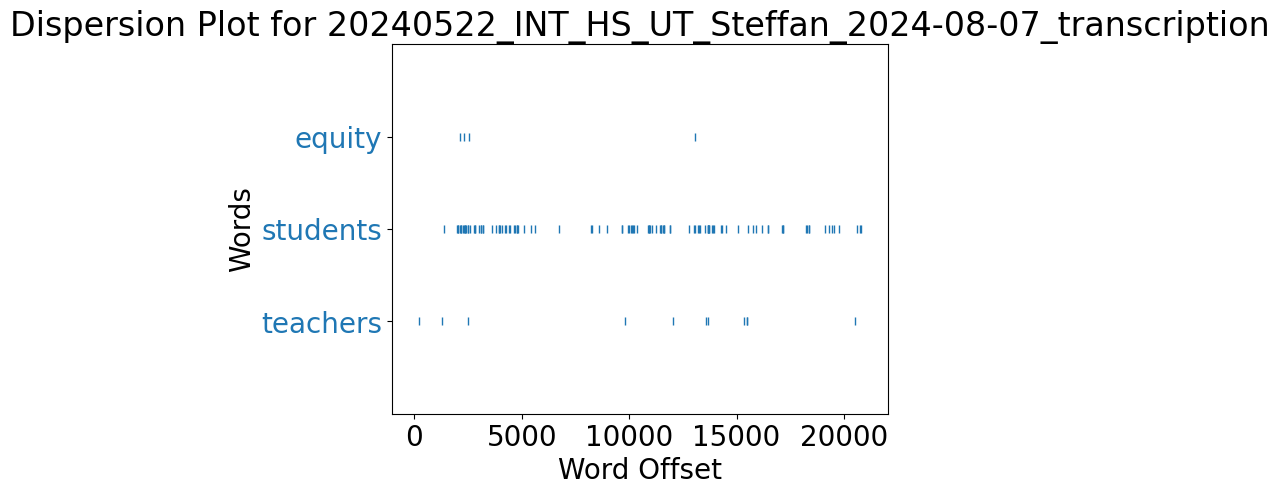

Dispersion plot for 20240531_INT_MS_Vera_2024-08-07_transcription:


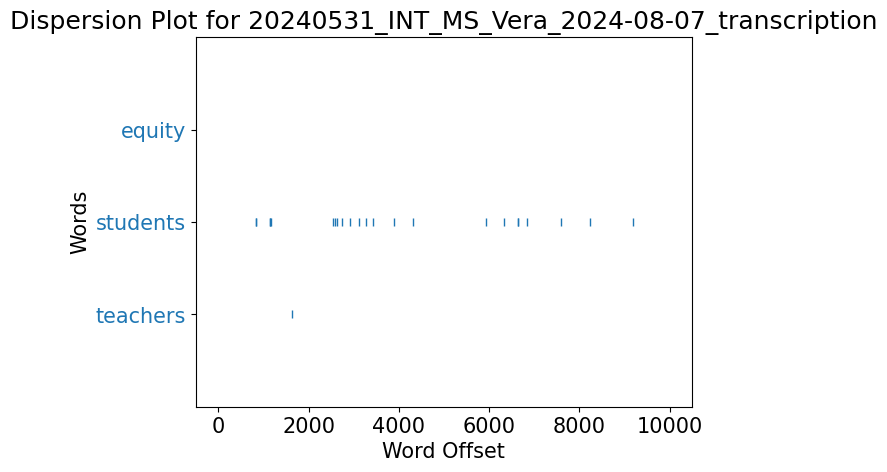

Dispersion plot for 20240531_INT_MS_Xander_2024-08-07_transcription:


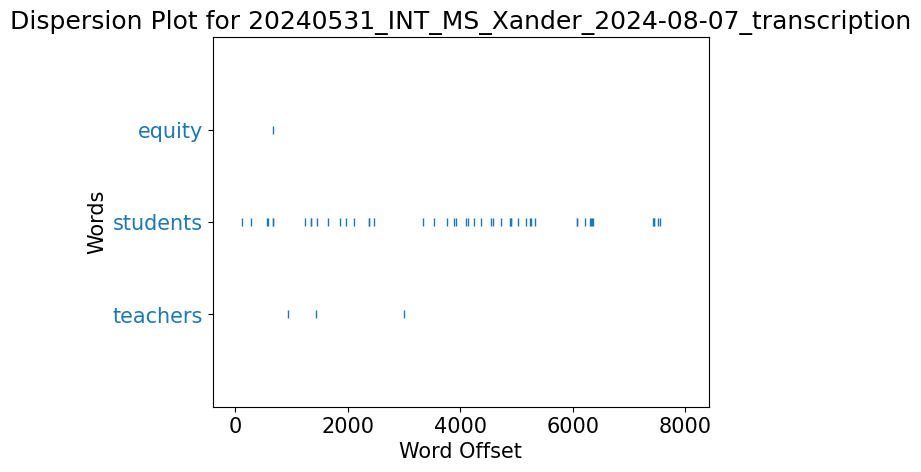

Dispersion plot for 20240603_INT_MS_Uma_2024-08-07_transcription:


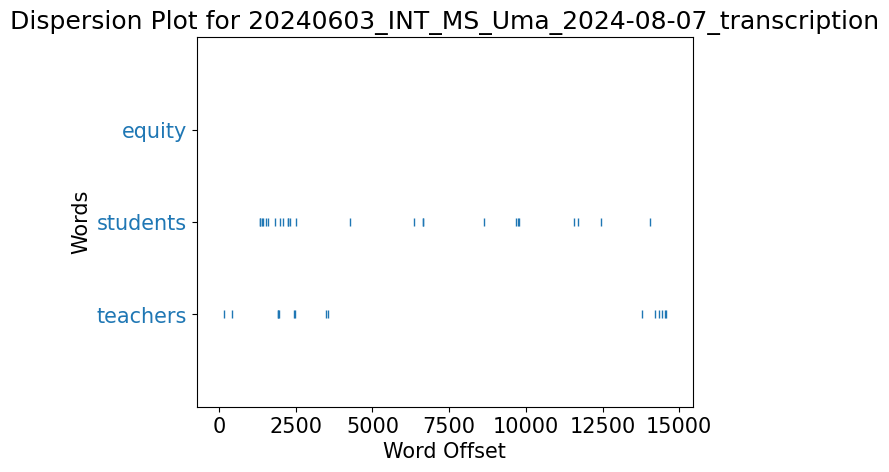

Dispersion plot for 20240606_INT_MS_Gloria_2024-08-07_transcription:


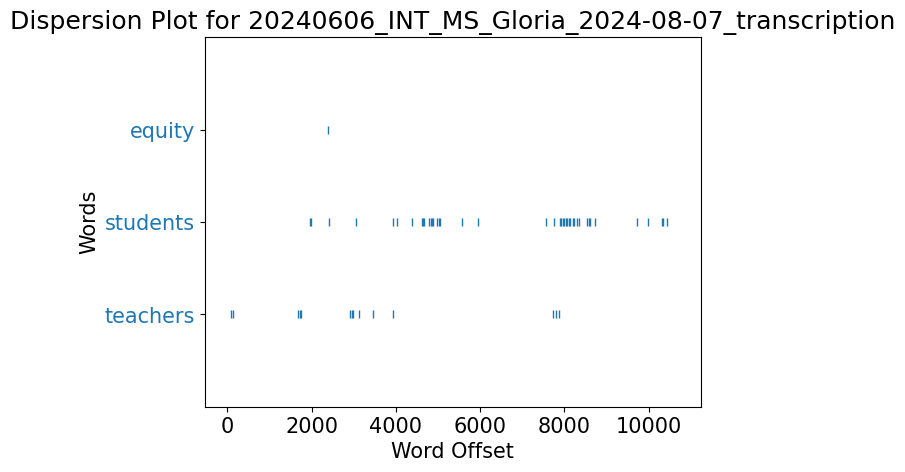

Dispersion plot for 20240612_INT_HS_Charles_2024-08-07_transcription:


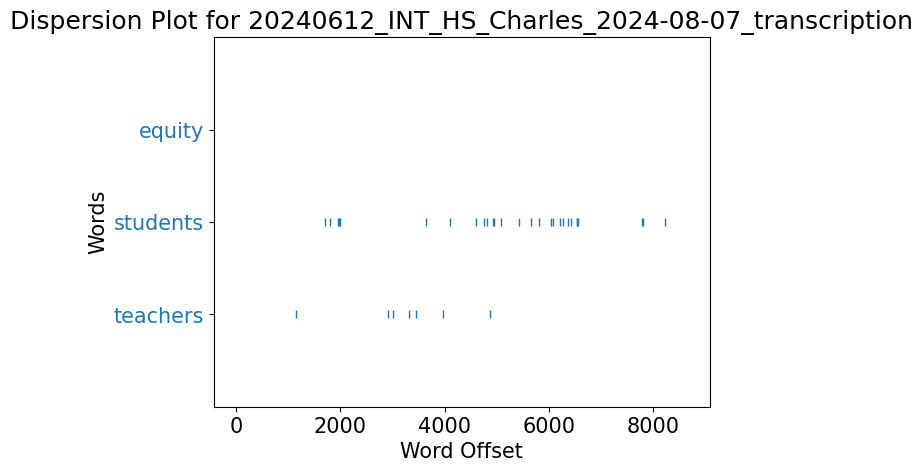

Dispersion plot for 20240718_INT_HS_Neil_2024-08-07_transcription:


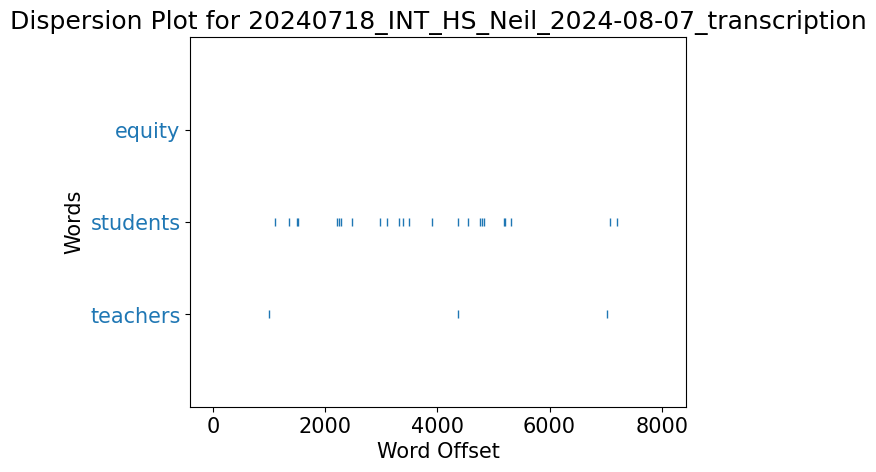

In [147]:
import matplotlib.pyplot as plt
import nltk

# 1. Words you want to track in the dispersion plot
words_to_track = ['equity', 'students', 'teachers']  # Add the words you want to track

# Convert words to lowercase if your text preprocessing converted all text to lowercase
words_to_track = [word.lower() for word in words_to_track]

# 2. Create dispersion plots for each transcript
for df, filename in processed_transcripts:
    # Retrieve the NLTK Text object from the DataFrame's attributes
    nltk_text_obj = df.attrs.get('nltk_text_object', None)

    if nltk_text_obj is not None:
        print(f"Dispersion plot for {filename}:")
        try:
            nltk_text_obj.dispersion_plot(words_to_track)
            plt.title(f"Dispersion Plot for {filename}")
            plt.xlabel('Word Offset')
            plt.ylabel('Words')
            plt.show()  # Show the plot for each file
            plt.rcParams.update({'font.size': 15})

        except Exception as e:
            print(f"Error in {filename}: {e}")
    else:
        print(f"No NLTK Text object available for {filename}")



# 7. Word Concordance Similarity:
You can compare concordances of different words to see which words appear in similar contexts. This can help in finding patterns of usage between related terms.

In [149]:
# Ensure NLTK is imported
import nltk

# 1. Define the words to compare
word1 = 'equity'
word2 = 'diversity'

# Convert words to lowercase if your text preprocessing converted all text to lowercase
word1 = word1.lower()
word2 = word2.lower()

# 2. Find and print similar contexts for the words in each transcript
def find_common_contexts(processed_transcripts, words):
    for df, filename in processed_transcripts:
        # Retrieve the NLTK Text object from the DataFrame's attributes
        nltk_text_obj = df.attrs.get('nltk_text_object', None)

        if nltk_text_obj is not None:
            print(f"Similar contexts for '{words[0]}' and '{words[1]}' in {filename}:")
            try:
                # Ensure that both words are in the text
                if words[0] in nltk_text_obj and words[1] in nltk_text_obj:
                    nltk_text_obj.common_contexts([words[0], words[1]])
                else:
                    missing_words = [word for word in words if word not in nltk_text_obj]
                    print(f"Words not found in {filename}: {', '.join(missing_words)}")
            except Exception as e:
                print(f"Error in {filename}: {e}")
            print("\n")
        else:
            print(f"No NLTK Text object available for {filename}")

# 3. Run the function on the processed transcripts
find_common_contexts(processed_transcripts, [word1, word2])



Similar contexts for 'equity' and 'diversity' in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
No common contexts were found


Similar contexts for 'equity' and 'diversity' in 20240531_INT_MS_Vera_2024-08-07_transcription:
Words not found in 20240531_INT_MS_Vera_2024-08-07_transcription: equity, diversity


Similar contexts for 'equity' and 'diversity' in 20240531_INT_MS_Xander_2024-08-07_transcription:
Words not found in 20240531_INT_MS_Xander_2024-08-07_transcription: diversity


Similar contexts for 'equity' and 'diversity' in 20240603_INT_MS_Uma_2024-08-07_transcription:
Words not found in 20240603_INT_MS_Uma_2024-08-07_transcription: equity, diversity


Similar contexts for 'equity' and 'diversity' in 20240606_INT_MS_Gloria_2024-08-07_transcription:
Words not found in 20240606_INT_MS_Gloria_2024-08-07_transcription: diversity


Similar contexts for 'equity' and 'diversity' in 20240612_INT_HS_Charles_2024-08-07_transcription:
Words not found in 20240612_INT_HS_Charles_2024-0

# 8. Named Entity Recognition (NER): Using spaCy

In [153]:
import os
import glob
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')  # Ensure you have this model installed

# 1. Function to extract entities from text using SpaCy
def extract_entities(text):
    doc = nlp(text)
    # Extract entities as a list of (entity text, entity label) tuples
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# 2. Function to process transcripts and extract entities
def process_transcripts_for_ner(processed_transcripts):
    entities_by_corpus = {}        # To store entities per corpus
    entity_counts_by_corpus = {}   # To store entity counts per corpus
    
    for df, filename in processed_transcripts:
        # Combine all text from the DataFrame into a single string
        full_text = ' '.join(df['text'].tolist())
        
        # Extract entities from the full text
        entities = extract_entities(full_text)
        
        # Store entities in a set for uniqueness
        entities_set = set([ent[0] for ent in entities])
        entities_by_corpus[filename] = entities_set
        
        # Count entity frequencies
        entity_counter = Counter([ent[0] for ent in entities])
        entity_counts_by_corpus[filename] = entity_counter
    
    return entities_by_corpus, entity_counts_by_corpus

# 3. Function to find unique entities per corpus
def find_unique_entities(entities_by_corpus):
    unique_entities = {}
    corpus_names = list(entities_by_corpus.keys())
    for corpus_name in corpus_names:
        other_corpora = corpus_names.copy()
        other_corpora.remove(corpus_name)
        # Union of entities from other corpora
        other_entities = set().union(*(entities_by_corpus[corp] for corp in other_corpora))
        # Entities unique to this corpus
        unique_entities[corpus_name] = entities_by_corpus[corpus_name] - other_entities
    return unique_entities

# 4. Function to find common entities across all corpora
def find_common_entities(entities_by_corpus):
    # Intersection of all entity sets
    common_entities = set.intersection(*entities_by_corpus.values())
    return common_entities

# 5. Function to create a DataFrame of entity frequencies across corpora
def create_entity_frequency_dataframe(entity_counts_by_corpus):
    # Get a set of all entities
    all_entities = set()
    for counts in entity_counts_by_corpus.values():
        all_entities.update(counts.keys())
    # Convert the set to a sorted list
    all_entities = sorted(list(all_entities))
    # Create a DataFrame with the index as the list of entities
    entity_freq_df = pd.DataFrame(index=all_entities)
    for corpus_name, counts in entity_counts_by_corpus.items():
        # Convert counts to a pandas Series
        counts_series = pd.Series(counts)
        # Align the series with the DataFrame index
        entity_freq_df[corpus_name] = counts_series
    # Fill NaN with zeros and convert to integer
    entity_freq_df = entity_freq_df.fillna(0).astype(int)
    # Add a total frequency column
    entity_freq_df['Total'] = entity_freq_df.sum(axis=1)
    # Sort by total frequency
    entity_freq_df = entity_freq_df.sort_values(by='Total', ascending=False)
    return entity_freq_df


# 6. Function to display results
def display_ner_comparison_results(entities_by_corpus, unique_entities_by_corpus, common_entities, entity_freq_df):
    # Display unique entities per corpus
    print("Unique Entities per Corpus:")
    for corpus_name, entities in unique_entities_by_corpus.items():
        print(f"\nUnique entities in {corpus_name}:")
        print(sorted(entities))
    
    # Display common entities across all corpora
    print("\nEntities common to all corpora:")
    print(sorted(common_entities))
    
    # Display the top entities by total frequency
    print("\nTop Entities by Total Frequency:")
    print(entity_freq_df.head(10))
    
    # Optionally, display the full frequency DataFrame
    # print("\nEntity Frequency DataFrame:")
    # print(entity_freq_df)

# 7. Main function to perform NER comparisons
def ner_comparison_across_corpora(processed_transcripts):
    # Extract entities and counts per corpus
    entities_by_corpus, entity_counts_by_corpus = process_transcripts_for_ner(processed_transcripts)
    
    # Find unique entities per corpus
    unique_entities_by_corpus = find_unique_entities(entities_by_corpus)
    
    # Find common entities across all corpora
    common_entities = find_common_entities(entities_by_corpus)
    
    # Create entity frequency DataFrame
    entity_freq_df = create_entity_frequency_dataframe(entity_counts_by_corpus)
    
    # Display the results
    display_ner_comparison_results(entities_by_corpus, unique_entities_by_corpus, common_entities, entity_freq_df)
    
    return entities_by_corpus, unique_entities_by_corpus, common_entities, entity_freq_df

# Example usage (after your existing processing pipeline)
if __name__ == "__main__":
    # Assuming you have already processed the transcripts and have 'processed_transcripts'
    # processed_transcripts = process_csv_files(base_dir)  # Uncomment if needed
    
    # Perform NER comparisons across corpora
    entities_by_corpus, unique_entities_by_corpus, common_entities, entity_freq_df = ner_comparison_across_corpora(processed_transcripts)



Unique Entities per Corpus:

Unique entities in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
['10 minutes', '14', '14 year olds', '16', '20-minute', '23-minute', '26', '40 minute', '50%', 'AMA', 'AP Environmental Science', 'Academy 9', 'Allstate', 'American Materials Association', 'Andrew Crane', 'Arctic', 'August', 'Bio', 'Cafe & Co.', 'Canada', 'Champagne', 'ChemPhys', 'Colorado State', 'Curricula', 'DCI', "Daniel Morales-Doyle's", 'DoorDash', 'EdWebs', 'Fingers', 'First year', 'Fs', 'IAP', 'Indiana', 'Kate', 'Kemp', 'Last year', 'Logan', 'Love', 'MGSS', 'May', 'Morales Doyle', 'Neil Migget', 'New York', 'Next year', 'Oftentimes', 'Orgo', 'Project Neuron', 'R18', 'RNA', 'Reasons', 'Society', 'Some days', 'Steena', 'TA', 'That week', 'The year', 'Violet', 'Waves', 'Wednesday', 'Zack', 'a couple of months ago', 'a couple weeks', 'a quarter', 'a ton', 'a work day', 'a year and a half', 'about eight', 'about it two months later', 'about the last year', 'almost 30 years', 'almost 

## Visualize Entity Frequency Across Corpora

In [154]:
# Plot top entities
top_entities = entity_freq_df.head(10)
top_entities.plot(kind='bar', y=['interview1.csv', 'interview2.csv', 'interview3.csv'], figsize=(10, 6))
plt.title('Top Entities Across Interviews')
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.show()


KeyError: "None of [Index(['interview1.csv', 'interview2.csv', 'interview3.csv'], dtype='object')] are in the [columns]"

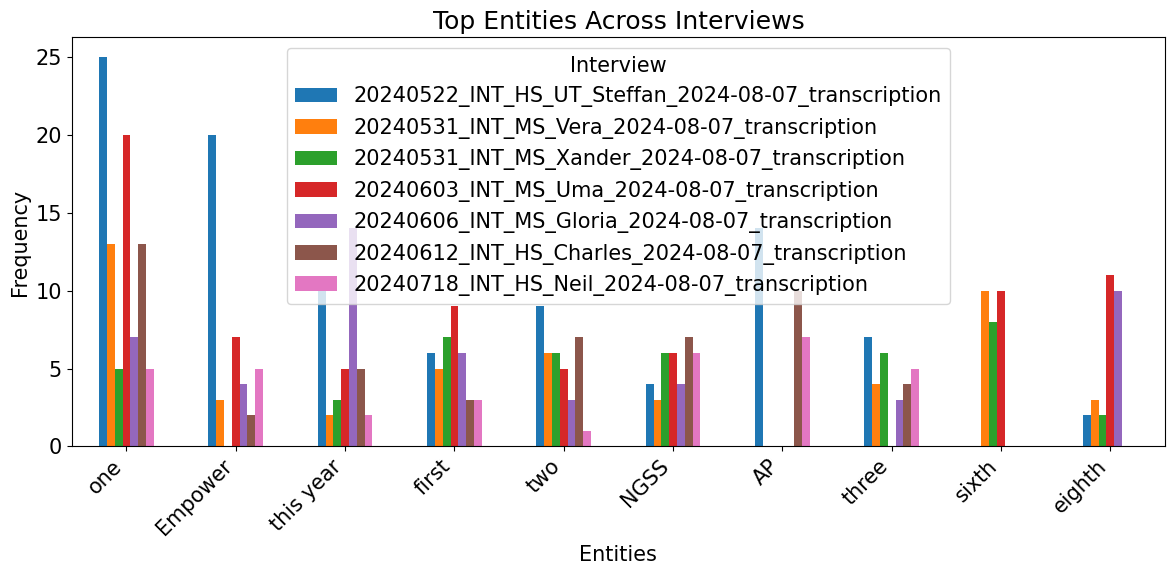

In [155]:
# Assuming 'entity_freq_df' is your DataFrame containing entity frequencies

# Get top entities
top_entities = entity_freq_df.head(10)

# Get the list of corpus names (column names) excluding 'Total'
corpus_names = [col for col in top_entities.columns if col != 'Total']

# Plot the top entities
ax = top_entities[corpus_names].plot(kind='bar', figsize=(12, 6))

# Set the title and labels
plt.title('Top Entities Across Interviews')
plt.xlabel('Entities')
plt.ylabel('Frequency')

# Adjust x-axis labels to improve readability
ax.set_xticklabels(top_entities.index, rotation=45, ha='right')

# Add legend with a title
plt.legend(title='Interview')

# Show the plot
plt.tight_layout()
plt.show()


In [158]:
def extract_entities(text, desired_entity_types=None, normalize=True):
    """
    Extract entities from text using SpaCy NER.

    Parameters:
    - text (str): The input text to process.
    - desired_entity_types (list, optional): List of entity types to include. If None, include all types.
    - normalize (bool): Whether to normalize entity text by stripping whitespace and punctuation.

    Returns:
    - entities (list of dict): List of entities with details.
    """
    if not text or not isinstance(text, str):
        return []
    
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        # Filter by desired entity types if provided
        if desired_entity_types and ent.label_ not in desired_entity_types:
            continue

        # Normalize entity text
        entity_text = ent.text.strip()
        if normalize:
            entity_text = entity_text.strip('''"'.,;:-''')

        entity_info = {
            'text': entity_text,
            'label': ent.label_,
            'start_char': ent.start_char,
            'end_char': ent.end_char
            # Add 'sentence_number' if needed
        }
        entities.append(entity_info)
    return entities



In [164]:
# Visualize entities in a sample text
from spacy import displacy

def visualize_sample_entities(text):
    doc = nlp(text)
    displacy.render(doc, style='ent', jupyter=True)

# Example usage
sample_text = df['text'].iloc[0]  # Get the first text entry from a DataFrame
visualize_sample_entities(sample_text)


c:\Users\mrhal\anaconda3\envs\test-env\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [163]:
# Example usage (after your existing processing pipeline)
if __name__ == "__main__":
    # Assuming you have already processed the transcripts and have 'processed_transcripts'

    # Specify the entity types you're interested in (optional)
    entity_types = ['PERSON', 'ORG', 'GPE', 'LOC']  # For example, focus on people, organizations, and locations

    # Perform NER comparisons across corpora with specified entity types
    entities_by_corpus, unique_entities_by_corpus, common_entities, entity_freq_df = ner_comparison_across_corpora(
        processed_transcripts, entity_types=entity_types)


TypeError: ner_comparison_across_corpora() got an unexpected keyword argument 'entity_types'

In [171]:
# Initialize dictionaries to store entities and counts
entities_by_corpus = {}
entity_counts_by_corpus = {}

# Define desired entity types (optional)
desired_entity_types = ['PERSON', 'ORG', 'GPE', 'LOC', 'EVENT']  # Adjust as needed

# Process each transcript
for df, filename in processed_transcripts:
    # Combine all text into one string
    full_text = ' '.join(df['text'].astype(str).tolist())

    # Extract entities
    entities = extract_entities(full_text, desired_entity_types=desired_entity_types, normalize=True)

    # Store entities by corpus
    entities_by_corpus[filename] = entities

    # Count entity frequencies
    entity_texts = [ent['text'] for ent in entities]
    entity_counts = Counter(entity_texts)
    entity_counts_by_corpus[filename] = entity_counts

print(entities_by_corpus)

{'20240522_INT_HS_UT_Steffan_2024-08-07_transcription': [{'text': 'AP', 'label': 'ORG', 'start_char': 269, 'end_char': 271}, {'text': 'PD', 'label': 'GPE', 'start_char': 1133, 'end_char': 1135}, {'text': 'Barbara', 'label': 'PERSON', 'start_char': 1521, 'end_char': 1528}, {'text': 'Barbara', 'label': 'PERSON', 'start_char': 2739, 'end_char': 2746}, {'text': 'Project Neuron', 'label': 'PERSON', 'start_char': 2754, 'end_char': 2768}, {'text': 'the normal grad school', 'label': 'ORG', 'start_char': 3379, 'end_char': 3401}, {'text': 'Kate', 'label': 'PERSON', 'start_char': 3728, 'end_char': 3732}, {'text': 'Barbara', 'label': 'PERSON', 'start_char': 4553, 'end_char': 4560}, {'text': 'American Materials Association', 'label': 'ORG', 'start_char': 4812, 'end_char': 4842}, {'text': 'AMA', 'label': 'ORG', 'start_char': 4864, 'end_char': 4867}, {'text': 'Society', 'label': 'ORG', 'start_char': 4938, 'end_char': 4945}, {'text': 'Barbara', 'label': 'PERSON', 'start_char': 5238, 'end_char': 5245},

In [173]:
print(set(entity_texts))

{'z', 'COVID', 'a Wonder of Science', 'Diana', 'Ashton', 'NGSS', 'Khan Academy', 'Neil', 'Paul Anderson', 'Kotak', 'Flynn', 'Natalie', 'Chicago', 'AP', 'Phenomenon Based', 'Empower', 'State', 'Barb', 'CU', 'Rantoul', 'TikToks'}


In [165]:
print(entity_counts)

Counter({'AP': 7, 'NGSS': 6, 'Diana': 5, 'Ashton': 5, 'COVID': 4, 'Empower': 3, 'Flynn': 2, 'Chicago': 1, 'State': 1, 'Rantoul': 1, 'a Wonder of Science': 1, 'Paul Anderson': 1, 'Barb': 1, 'CU': 1, 'Kotak': 1, 'TikToks': 1, 'Khan Academy': 1, 'z': 1, 'Phenomenon Based': 1, 'Natalie': 1, 'Neil': 1})


# fix

In [166]:
# Function to process texts and extract entities
def process_and_extract_entities(texts):
    entities_list = []
    for text in texts:
        doc = nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        entities_list.append(entities)
    return entities_list

# Example usage with your DataFrame
for df, filename in processed_transcripts:
    texts = df['text'].astype(str).tolist()
    entities_list = process_and_extract_entities(texts)
    
    # Add entities to DataFrame
    df['entities'] = entities_list
    
    # Visualize entities in the first text
    print(f"Entities in {filename}:")
    if entities_list[0]:
        visualize_sample_entities(texts[0])
    else:
        print("No entities found in the first text.")


Entities in 20240522_INT_HS_UT_Steffan_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240531_INT_MS_Vera_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240531_INT_MS_Xander_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240603_INT_MS_Uma_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240606_INT_MS_Gloria_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240612_INT_HS_Charles_2024-08-07_transcription:
No entities found in the first text.
Entities in 20240718_INT_HS_Neil_2024-08-07_transcription:
No entities found in the first text.


In [167]:
unique_entities_by_corpus = {}
corpus_names = list(entities_by_corpus.keys())
for corpus_name in corpus_names:
    other_corpora = corpus_names.copy()
    other_corpora.remove(corpus_name)
    # Collect entities from other corpora
    other_entities = set(ent['text'] for other_corpus in other_corpora for ent in entities_by_corpus[other_corpus])
    # Entities unique to the current corpus
    current_entities = set(ent['text'] for ent in entities_by_corpus[corpus_name])
    unique_entities = current_entities - other_entities
    unique_entities_by_corpus[corpus_name] = unique_entities
print(unique_entities_by_corpus)

{'20240522_INT_HS_UT_Steffan_2024-08-07_transcription': {'Steena', 'Neil Migget', 'Morales Doyle', 'Kate', 'Cafe & Co', 'New York', 'TA', 'Andrew Crane', 'Society', 'us', 'Allstate', 'Logan', 'Fingers', 'the normal grad school', 'Waves', 'Colorado State', 'American Materials Association', 'IAP', 'the Arctic Circle', 'DCI', 'Curricula', "Daniel Morales-Doyle's", 'Orgo', 'AMA', 'Violet', 'DoorDash', 'Oftentimes', 'MGSS', 'AP Environmental Science', 'Zack', 'R18', 'Kemp', 'Indiana', 'Project Neuron', 'Reasons', 'Champagne', 'Bio', 'Arctic', 'Canada', 'RNA'}, '20240531_INT_MS_Vera_2024-08-07_transcription': {'NASA', 'loaner Chromebooks', 'CUP', 'the Stanley Cup', 'CPS', 'Erica', 'NSGS', 'Peoria', 'a Stanley Cup', 'the Future Teachers of America Club', 'Erica Mason', 'I', 'SIAD', 'Illinois at Bradley University', 'A2', 'Washington', 'the Stanley Cups', 'A1'}, '20240531_INT_MS_Xander_2024-08-07_transcription': {'Wilson', 'Newton', 'Miyagi', 'Particular', 'Centennial', 'Chick', 'McDonald'}, '

In [168]:
# Get sets of entity texts for each corpus
entity_sets = [set(ent['text'] for ent in entities) for entities in entities_by_corpus.values()]
common_entities = set.intersection(*entity_sets)

print(common_entities)

{'NGSS'}


In [170]:
def create_entity_frequency_dataframe(entity_counts_by_corpus):
    # Get all unique entities
    all_entities = set()
    for counts in entity_counts_by_corpus.values():
        all_entities.update(counts.keys())
    all_entities = sorted(list(all_entities))
    # Create DataFrame
    entity_freq_df = pd.DataFrame(index=all_entities)
    for corpus_name, counts in entity_counts_by_corpus.items():
        counts_series = pd.Series(counts)
        entity_freq_df[corpus_name] = counts_series
    # Fill NaN with zeros
    entity_freq_df = entity_freq_df.fillna(0).astype(int)
    # Add total frequency
    entity_freq_df['Total'] = entity_freq_df.sum(axis=1)
    # Sort by total frequency
print(entity_freq_df)

                         20240522_INT_HS_UT_Steffan_2024-08-07_transcription  \
one                                                                     25     
Empower                                                                 20     
this year                                                               10     
first                                                                    6     
two                                                                      9     
...                                                                    ...     
SmallTown Middle School                                                  0     
September, October-ish                                                   0     
Second                                                                   0     
STEM                                                                     0     
z.                                                                       0     

                         20240531_INT_M

# 10. Sentiment Analysis (Using TextBlob):
You can integrate sentiment analysis into the pipeline to examine the sentiment polarity of different sections of text.

In [176]:
from textblob import TextBlob

# Loop over the processed transcripts
for df, filename in processed_transcripts:
    # Retrieve the NLTK Text object from the DataFrame's attributes
    nltk_text_obj = df.attrs.get('nltk_text_object', None)
    
    if nltk_text_obj is not None:
        # Convert NLTK Text object back to string for sentiment analysis
        text = ' '.join(nltk_text_obj)
        blob = TextBlob(text)
        print(f"Sentiment polarity for {filename}: {blob.sentiment.polarity}")
        print(f"Sentiment subjectivity for {filename}: {blob.sentiment.subjectivity}")
        print("\n")
    else:
        print(f"No NLTK Text object available for {filename}")


Sentiment polarity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.18584736384305248
Sentiment subjectivity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.5085033075898476


Sentiment polarity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.21817892025330046
Sentiment subjectivity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.48339713546325


Sentiment polarity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.24900272749136332
Sentiment subjectivity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.5291692247146784


Sentiment polarity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.2153926650343399
Sentiment subjectivity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.5217018716205584


Sentiment polarity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.15511533298653468
Sentiment subjectivity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.48828653045849135


Sentiment polarity for 20240612_INT_HS_Charles_2024-08-07_t

Sentiment polarity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.18584736384305248
Sentiment subjectivity for 20240522_INT_HS_UT_Steffan_2024-08-07_transcription: 0.5085033075898476


Sentiment polarity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.21817892025330046
Sentiment subjectivity for 20240531_INT_MS_Vera_2024-08-07_transcription: 0.48339713546325


Sentiment polarity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.24900272749136332
Sentiment subjectivity for 20240531_INT_MS_Xander_2024-08-07_transcription: 0.5291692247146784


Sentiment polarity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.2153926650343399
Sentiment subjectivity for 20240603_INT_MS_Uma_2024-08-07_transcription: 0.5217018716205584


Sentiment polarity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.15511533298653468
Sentiment subjectivity for 20240606_INT_MS_Gloria_2024-08-07_transcription: 0.48828653045849135


Sentiment polarity for 20240612_INT_HS_Charles_2024-08-07_t

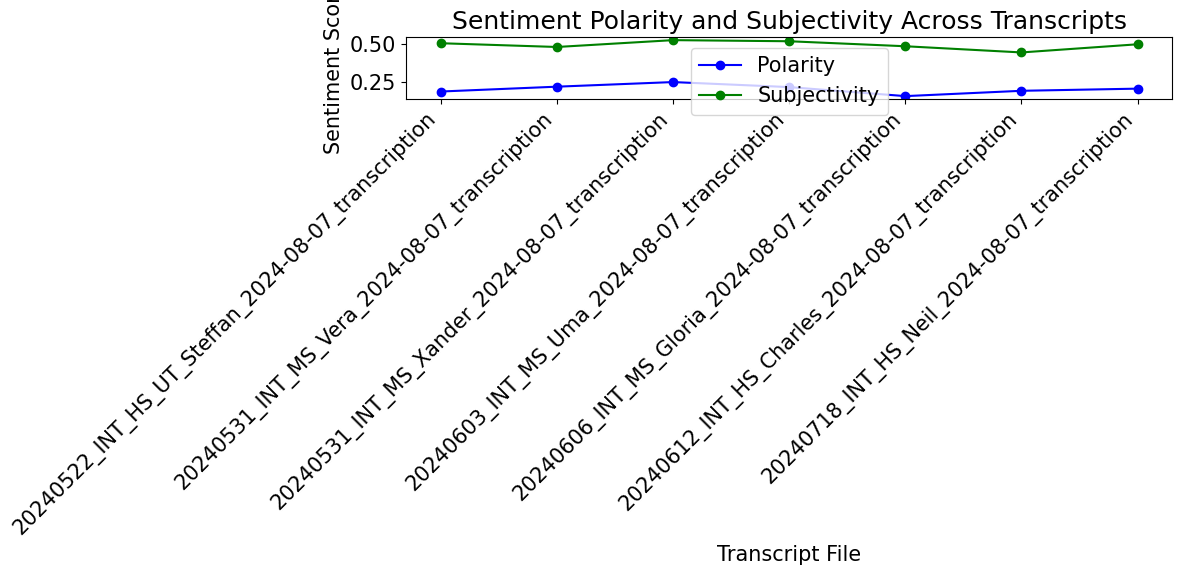

In [179]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import os

# Lists to store results for plotting
file_paths = []
polarity_scores = []
subjectivity_scores = []

# Sentiment analysis using TextBlob
for df, filename in processed_transcripts:
    # Retrieve the NLTK Text object from the DataFrame's attributes
    nltk_text_obj = df.attrs.get('nltk_text_object', None)
    
    if nltk_text_obj is not None:
        # Convert NLTK Text object back to string for sentiment analysis
        text = ' '.join(nltk_text_obj)
        blob = TextBlob(text)
        
        # Append the shortened file name and sentiment scores for plotting
        short_name = os.path.basename(filename)
        file_paths.append(short_name)
        polarity_scores.append(blob.sentiment.polarity)
        subjectivity_scores.append(blob.sentiment.subjectivity)
        
        # Print the sentiment analysis results
        print(f"Sentiment polarity for {filename}: {blob.sentiment.polarity}")
        print(f"Sentiment subjectivity for {filename}: {blob.sentiment.subjectivity}")
        print("\n")
    else:
        print(f"No NLTK Text object available for {filename}")

# Plotting sentiment polarity and subjectivity
plt.figure(figsize=(12, 6))  # Increased figure size for better readability

# Plot polarity
plt.plot(file_paths, polarity_scores, marker='o', label='Polarity', color='blue')

# Plot subjectivity
plt.plot(file_paths, subjectivity_scores, marker='o', label='Subjectivity', color='green')

# Formatting the plot
plt.title('Sentiment Polarity and Subjectivity Across Transcripts')
plt.xlabel('Transcript File')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()


## 3.00 Word Frequency Distribution

### 3.01 Bag of Words Frequency distribution

This will search for each word in the bag of words to find its frequency in each text corpus.

In [180]:
import nltk
from nltk.probability import FreqDist
import pandas as pd
import os

# List of keywords to track (remove duplicates and sort)
keywords = sorted(set([
    'students', 'science', 'engagement', 'ability', 'community', 'talk',
    'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations',
    'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
    'engaging', 'literacy', 'kids', 'connect', 'student', 'classroom',
    'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking',
    'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'questions',
    'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'conversation', 'hard', 'saying'
]))

# Initialize a dictionary to hold frequency distributions for each corpus
freq_distributions = {}

# Process the transcripts that have been previously preprocessed into 'processed_transcripts'
for i, (df, filename) in enumerate(processed_transcripts):
    # Check if 'nltk_unprocessed_word_tokens' column exists in df
    if 'nltk_unprocessed_word_tokens' in df.columns:
        # Get word tokens for each transcript
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        
        # Convert tokens to lowercase for consistent matching
        word_tokens = [word.lower() for word in word_tokens]
        
        # Calculate the frequency distribution of the tokens
        freq_dist = FreqDist(word_tokens)
        
        # Store the frequency of each keyword in the dictionary for this corpus
        corpus_name = os.path.basename(filename)  # Use the filename as the corpus name
        freq_distributions[corpus_name] = {word: freq_dist[word] for word in keywords}
    else:
        print(f"'nltk_unprocessed_word_tokens' column not found in {filename}")

# Convert the frequency distributions to a DataFrame for easy visualization and analysis
freq_df = pd.DataFrame(freq_distributions)

# Transpose the DataFrame so that each row represents a transcript
freq_df = freq_df.transpose()

# Print the DataFrame
print(freq_df)

# Save the result to a CSV file if needed
# freq_df.to_csv('keyword_frequencies.csv', index=True)


                                                    ability  actually  ap  \
20240522_INT_HS_UT_Steffan_2024-08-07_transcrip...        1        17  15   
20240531_INT_MS_Vera_2024-08-07_transcription             1        12   0   
20240531_INT_MS_Xander_2024-08-07_transcription           0        19   0   
20240603_INT_MS_Uma_2024-08-07_transcription              1         6   0   
20240606_INT_MS_Gloria_2024-08-07_transcription           3         8   0   
20240612_INT_HS_Charles_2024-08-07_transcription          0        14  10   
20240718_INT_HS_Neil_2024-08-07_transcription             0         1   7   

                                                    approach  assessment  \
20240522_INT_HS_UT_Steffan_2024-08-07_transcrip...         0           0   
20240531_INT_MS_Vera_2024-08-07_transcription              0           0   
20240531_INT_MS_Xander_2024-08-07_transcription            0           0   
20240603_INT_MS_Uma_2024-08-07_transcription               1           1   
202

### 3.02 Bag of Words Frequency Distribution with Plots

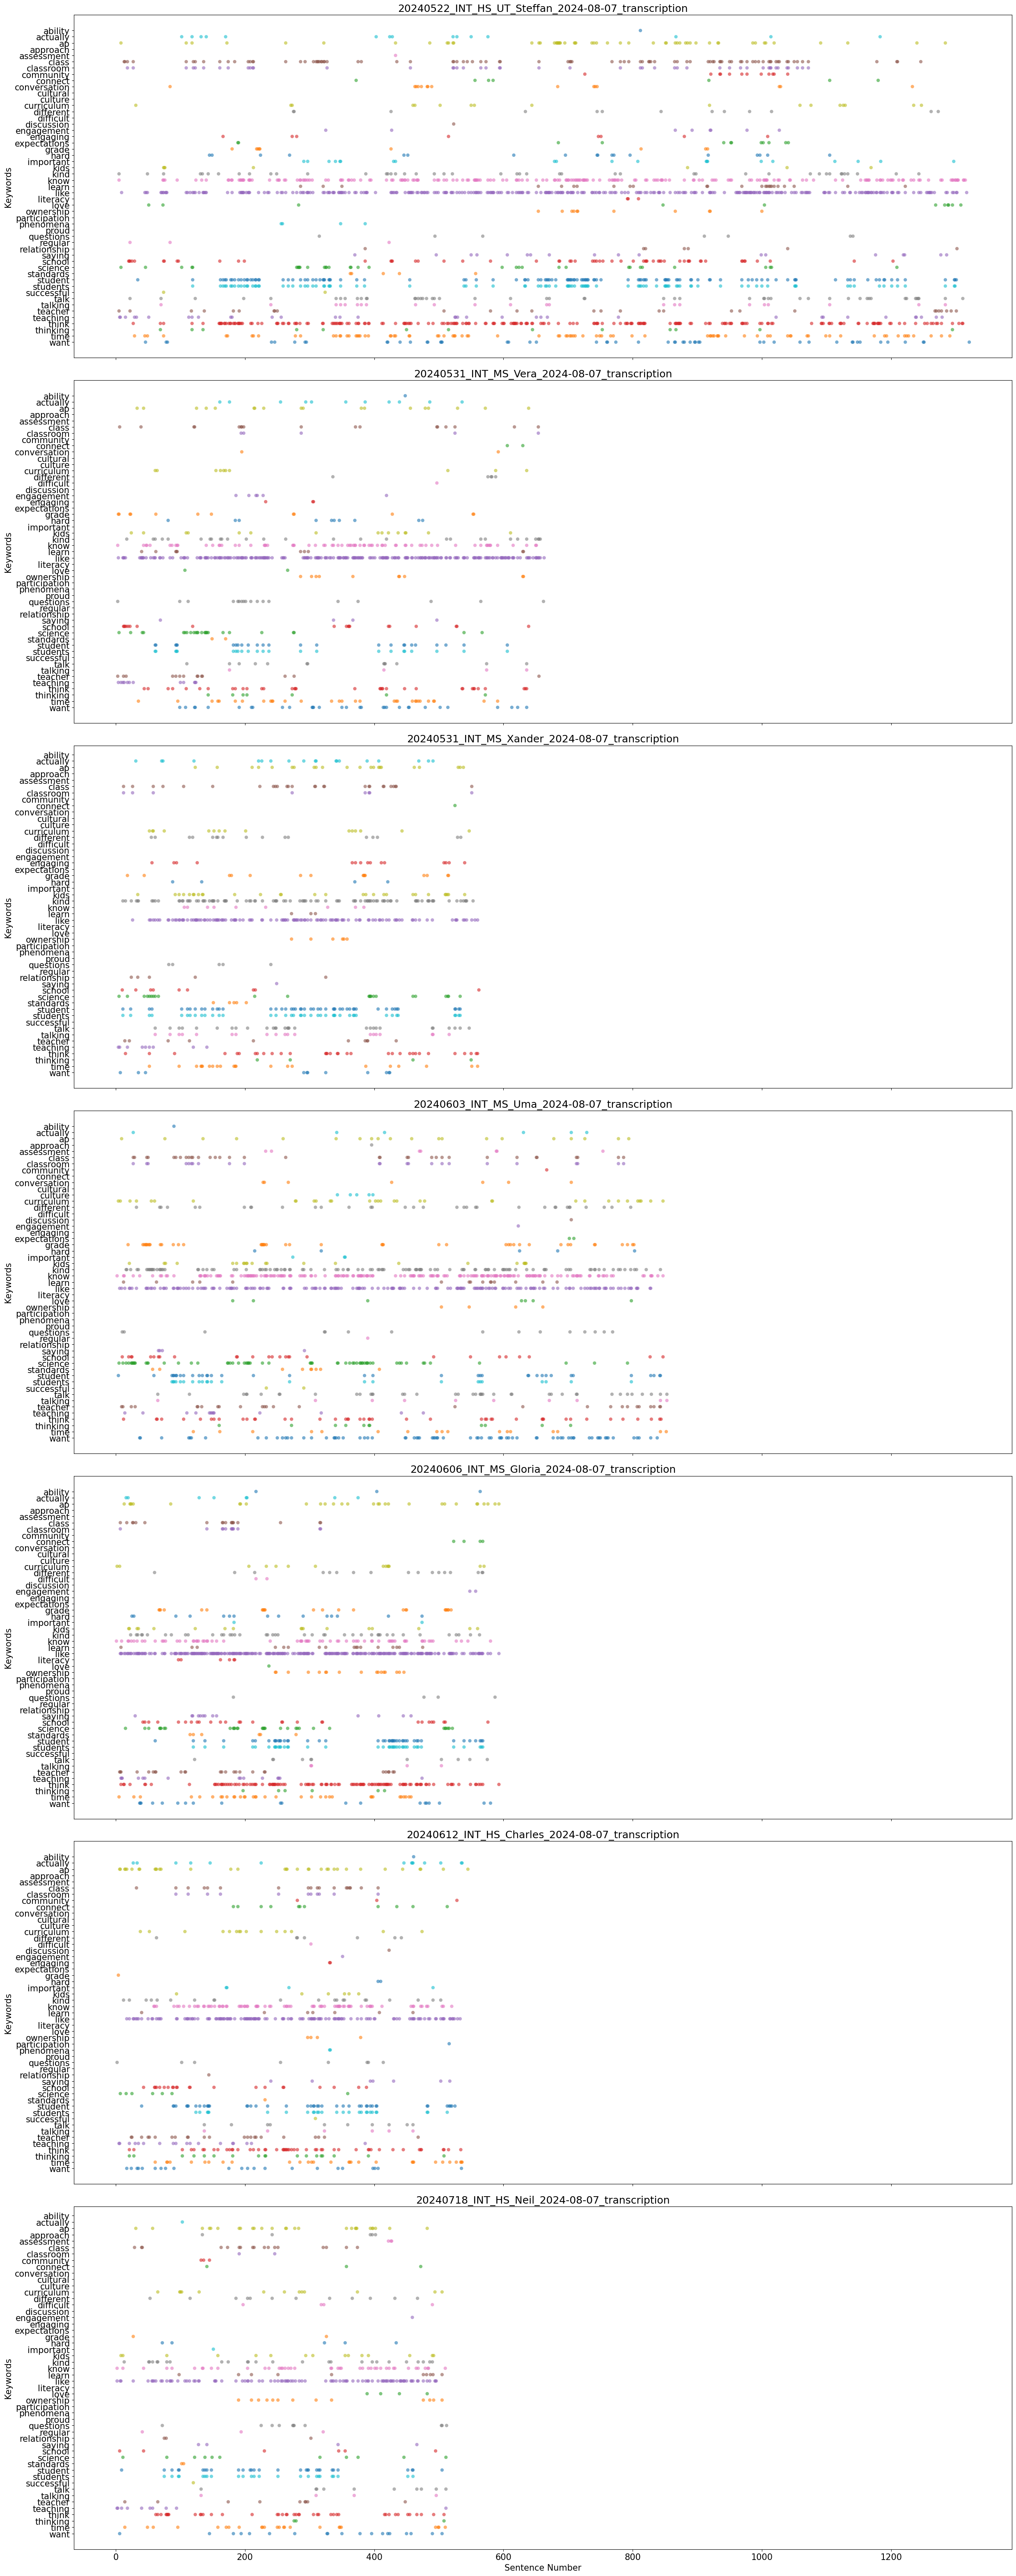

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Example keywords to track (remove duplicates and sort in reverse for plotting)
keywords = sorted(set([
    'students', 'science', 'engagement', 'ability', 'community', 'talk',
    'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations',
    'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
    'engaging', 'literacy', 'kids', 'connect', 'student', 'classroom',
    'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking',
    'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'questions',
    'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'conversation',
    'hard', 'saying'
]), reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Number of transcripts (corpora)
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig, axes = plt.subplots(num_corpora, 1, figsize=(25, num_corpora * 9), sharex=True)

# Convert axes to an array if it's not (happens when num_corpora is 1)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate over each transcript and plot keyword occurrences
for ax, (i, (df, filename)) in zip(axes, enumerate(processed_transcripts)):
    corpus_name = os.path.basename(filename)
    ax.set_title(f"{corpus_name}")
    
    # Check if 'nltk_unprocessed_sentence_tokens' column exists
    if 'nltk_unprocessed_sentence_tokens' in df.columns:
        # Get the sentence tokens from each transcript
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().dropna().tolist()  # Flatten and remove NaN
        
        # Plot the occurrences of each keyword
        for keyword in keywords:
            occurrences = [(i + 1, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
            sentence_nums = [occ[1] for occ in occurrences]
            
            y_values = np.full(len(sentence_nums), keyword_mapping[keyword])
            ax.scatter(sentence_nums, y_values, label=keyword, alpha=0.6, edgecolors='none')
        
        ax.set_yticks(list(keyword_mapping.values()))
        ax.set_yticklabels(list(keyword_mapping.keys()))
        ax.set_ylabel('Keywords')
    else:
        print(f"'nltk_unprocessed_sentence_tokens' column not found in {filename}")
        continue  # Skip this transcript if the required column is missing

# Adjust layout and labels
plt.xlabel('Sentence Number')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure to an image file before displaying
plt.savefig('data/my_keyword_plots.png', bbox_inches='tight')

plt.show()


                                                    ability  actually  ap  \
20240522_INT_HS_UT_Steffan_2024-08-07_transcrip...        2        17  15   
20240531_INT_MS_Vera_2024-08-07_transcription             1        12   0   
20240531_INT_MS_Xander_2024-08-07_transcription           0        19   0   
20240603_INT_MS_Uma_2024-08-07_transcription              1         6   0   
20240606_INT_MS_Gloria_2024-08-07_transcription           3         8   0   
20240612_INT_HS_Charles_2024-08-07_transcription          0        14  10   
20240718_INT_HS_Neil_2024-08-07_transcription             0         1   7   

                                                    approach  assessment  \
20240522_INT_HS_UT_Steffan_2024-08-07_transcrip...         0           1   
20240531_INT_MS_Vera_2024-08-07_transcription              0           0   
20240531_INT_MS_Xander_2024-08-07_transcription            0           0   
20240603_INT_MS_Uma_2024-08-07_transcription               1           1   
202

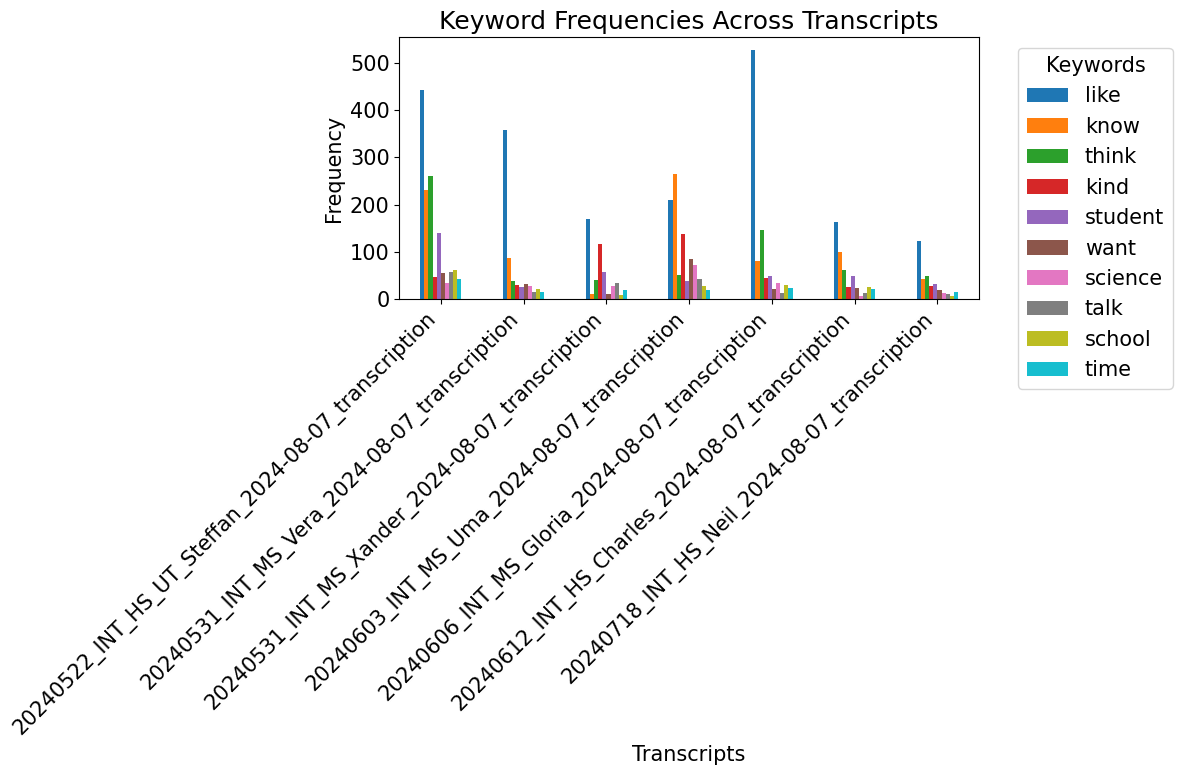

In [182]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# List of keywords to track (remove duplicates and sort)
keywords = sorted(set([
    'students', 'science', 'engagement', 'ability', 'community', 'talk',
    'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations',
    'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
    'engaging', 'literacy', 'kids', 'connect', 'student', 'classroom',
    'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking',
    'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'questions',
    'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'conversation',
    'hard', 'saying'
]))

# Initialize a dictionary to hold frequency distributions for each transcript
keyword_frequencies = {}

# Process the transcripts that have been previously preprocessed into 'processed_transcripts'
for df, filename in processed_transcripts:
    # Use the processed word tokens (e.g., lemmatized and lowercased)
    if 'nltk_processed_word_tokens' in df.columns:
        # Flatten the list of tokens and remove NaN values
        word_tokens = df['nltk_processed_word_tokens'].explode().dropna().tolist()
        
        # Ensure tokens are strings and convert to lowercase
        word_tokens = [str(word).lower() for word in word_tokens]
        
        # Calculate the frequency distribution of the tokens
        freq_dist = nltk.FreqDist(word_tokens)
        
        # Store the frequency of each keyword for this transcript
        transcript_name = os.path.basename(filename)
        keyword_frequencies[transcript_name] = {keyword: freq_dist[keyword] for keyword in keywords}
    else:
        print(f"'nltk_processed_word_tokens' column not found in {filename}")

# Convert the keyword frequencies to a DataFrame
freq_df = pd.DataFrame(keyword_frequencies).fillna(0).astype(int)

# Transpose the DataFrame so that each row represents a transcript
freq_df = freq_df.transpose()

# Print the DataFrame for inspection
print(freq_df)

# Plotting the keyword frequencies
# You can choose to plot all keywords or focus on a subset
# For readability, let's focus on the top N keywords across all transcripts
N = 10  # Number of top keywords to plot

# Calculate total frequencies for each keyword across all transcripts
total_keyword_frequencies = freq_df.sum(axis=0)

# Get the top N keywords
top_keywords = total_keyword_frequencies.sort_values(ascending=False).head(N).index.tolist()

# Plot the frequencies of the top keywords
freq_df[top_keywords].plot(kind='bar', figsize=(12, 8))

plt.title('Keyword Frequencies Across Transcripts')
plt.xlabel('Transcripts')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Keywords', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Optionally, save the plot to a file
# plt.savefig('keyword_frequencies_plot.png', bbox_inches='tight')

# Save the frequency DataFrame to a CSV file if needed
# freq_df.to_csv('keyword_frequencies.csv', index=True)


## Heatmap

In [ ]:
import seaborn as sns

# Create a matrix of keywords vs. sentences
# Implement accordingly based on your data structure


### 3.03 Combined

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Example keywords to track
keywords = ['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
            "engaging", 'literacy', 'relationship', 'kids', 'connect', 'student', 'classroom', 
            'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking', 
            'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'know', 'questions', 'know',
            'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'talk', 'conversation', 
            'discussion', 'hard', 'saying']

# Map keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Create a figure with an increased height to better fit the number of keywords
fig = go.Figure()

# Process each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Loop through keywords and plot occurrences in sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences if occ[0] == transcript_name]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Adding traces for each keyword
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers', name=keyword,
                                 text=[f'Sentence: {num}' for num in sentence_nums],
                                 marker=dict(size=8, opacity=0.6)))

# Update layout with an appropriate height and labels
fig.update_layout(title='Keyword Occurrence Across Sentences in Multiple Transcripts',
                  xaxis_title='Sentence Number',
                  yaxis=dict(tickmode='array', tickvals=list(keyword_mapping.values()), ticktext=list(keyword_mapping.keys())),
                  legend_title='Keywords',
                  height=1200)  # Adjust height based on number of keywords

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()



### 3.04 Side to side

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Number of transcripts (corpora) to be displayed
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig = make_subplots(rows=1, cols=num_corpora, subplot_titles=[f"Transcript {i + 1}" for i in range(num_corpora)])

# Example keywords to track, sorted for consistency across the plot
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 
            'relationship', 'engaging', 'literacy', 'relationship', 'kids', 'connect', 
            'student', 'classroom', 'teacher', 'teaching', 'school', 'class', 'curriculum', 
            'learn', 'approach', 'talking', 'discussion', 'love', 'proud', 'like', 'difficult', 
            'actually', 'know', 'questions', 'think', 'want', 'kind', 'time', 'grade', 
            'thinking', 'different', 'talk', 'conversation', 'discussion', 'hard', 'saying'], reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Index for the current subplot
col_index = 1

# Loop through each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Plot the occurrences of each keyword in the sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Add traces for each keyword to the respective subplot
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers', name=keyword,
                                 text=[f'Sentence: {num}' for num in sentence_nums],
                                 marker=dict(size=10, opacity=0.5)),  # Adjust marker size for visibility
                      row=1, col=col_index)

    col_index += 1  # Move to the next subplot for the next transcript

# Update layout to ensure all keywords are visible
fig.update_layout(
    title='Keyword Occurrence Across Sentences in Multiple Transcripts',
    xaxis_title='Sentence Number',
    yaxis=dict(
        tickmode='array',
        tickvals=list(keyword_mapping.values()),
        ticktext=list(keyword_mapping.keys())
    ),
    legend_title='Keywords',
    height=1200,  # Increase height to accommodate all keywords
    showlegend=True
)

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()


### 3.05 Needs fixing

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Number of transcripts (corpora) to be displayed
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig = make_subplots(rows=1, cols=num_corpora, subplot_titles=[f"Transcript {i+1}" for i in range(num_corpora)])

# Example keywords to track, sorted for consistency across the plot
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 
            'relationship', 'engaging', 'literacy', 'relationship', 'kids', 'connect', 
            'student', 'classroom', 'teacher', 'teaching', 'school', 'class', 'curriculum', 
            'learn', 'approach', 'talking', 'discussion', 'love', 'proud', 'like', 'difficult', 
            'actually', 'know', 'questions', 'think', 'want', 'kind', 'time', 'grade', 
            'thinking', 'different', 'talk', 'conversation', 'discussion', 'hard', 'saying'], reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Loop through each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Plot the occurrences of each keyword in the sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Add traces for each keyword
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers',
                                 text=[f'{keyword} (Sentence: {num})' for num in sentence_nums],
                                 marker=dict(size=10, opacity=0.5),
                                 showlegend=False),  # This prevents adding each keyword to the legend multiple times
                      row=1, col=i+1)

# Update layout
fig.update_layout(
    title='Keyword Occurrence Across Sentences in Multiple Transcripts',
    xaxis_title='Sentence Number',
    yaxis=dict(
        tickmode='array',
        tickvals=list(keyword_mapping.values()),
        ticktext=list(keyword_mapping.keys())
    ),
    height=1200,  # Increase height to accommodate all keywords
)

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()



## 4.00 Additional Resources

## Step 3: Topic Modeling and Semantic Similarities Across Transcriptions
Generating Sentence Embeddings for Each Transcription
We'll generate embeddings for each transcription and store them.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Store embeddings and related info
embeddings_list = []
file_names = []

# Loop through each transcript DataFrame in processed_transcripts
for i, df in enumerate(processed_transcripts):
    # Join the cleaned text from each transcript
    text = ' '.join(df['cleaned_text'])  # Assuming cleaned text is stored in 'cleaned_text' column
    
    # Generate embeddings for the entire transcript text
    embedding = model.encode(text)
    
    # Append the embedding and source file name
    embeddings_list.append(embedding)
    
    # Assuming the transcript DataFrame has a 'source_file' column or use a placeholder like 'Transcript {i+1}'
    file_names.append(f"Transcript {i + 1}" if 'source_file' not in df.columns else df['source_file'].iloc[0])

# Convert embeddings and file names into a dictionary for further use
embedding_data = {
    'file_names': file_names,
    'embeddings': embeddings_list
}

# Example: Use embeddings_data for further analysis, e.g., comparing semantic similarity
print("Embeddings have been generated for each transcript.")



## Comparing Transcriptions Using Semantic Similarity
We'll compute the cosine similarity between each pair of transcriptions.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Load SentenceTransformer and generate embeddings (from previous code)
# Assuming embeddings_list and file_names have already been generated as shown in the previous code

# Step 2: Convert list of embeddings to a numpy array
embeddings_array = np.vstack(embeddings_list)

# Step 3: Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_array)

# Step 4: Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)

# Step 5: Print or visualize the similarity matrix
print(similarity_df)

# Optional: Save the similarity matrix to a CSV file for further analysis
similarity_df.to_csv('data/transcript_similarity_matrix.csv')



## Visualizing the Similarity Matrix

# Topic Modeling on Individual Transcriptions
Using Latent Dirichlet Allocation (LDA)
First, you need to prepare the data for LDA:

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Function to perform LDA
def perform_lda(tokens_list, num_topics=5):
    # Create a dictionary representation of the documents
    dictionary = Dictionary(tokens_list)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=1, no_above=0.5)

    # Create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]

    # Train the LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    
    return lda, corpus, dictionary

# Step 1: Extract word tokens from the processed transcripts
tokens_list = []

for df in processed_transcripts:
    # Extract word tokens from each transcript and flatten them into a list
    tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()
    
    # Add tokenized transcript to the list
    tokens_list.append(tokens)

# Step 2: Perform LDA on the extracted tokens
lda_model, corpus, dictionary = perform_lda(tokens_list, num_topics=5)

# Step 3: Print the topics discovered by the LDA model
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx + 1}: {topic}")
